# Solar Flare Prediction Data Processing

## Expected Output:
- Clean time-series data with HMI magnetic field features
- Binary flare occurrence labels aligned to observations
- Train/validation/test splits ready for LSTM model

In [1]:
# Import required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from astropy.io import fits
import warnings
from pathlib import Path
import re
from typing import Dict, List, Tuple, Optional
import seaborn as sns
from collections import Counter

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

## Define Paths and Find Available Data

In [2]:
# Define data paths
DATA_DIR = Path("data")
UTIL_DIR = Path("util")

# Check years available
event_years = [d.name.replace("_events", "") for d in DATA_DIR.glob("*_events")]
hmi_dates = [d.name.split(".")[2] for d in DATA_DIR.glob("hmi*")]

print(f"\n=== AVAILABLE DATA ===")
print(f"Event classification years: {sorted(event_years)}")
print(f"HMI magnetic field dates: {sorted(hmi_dates)}")

# Check if we have both event and HMI data for overlapping periods
print(f"\n=== DATA COVERAGE ===")
for year in sorted(event_years):
    hmi_files_for_year = list(DATA_DIR.glob(f"hmi*{year}*"))
    print(f"Year {year}: {len(hmi_files_for_year)} HMI data sets available")


=== AVAILABLE DATA ===
Event classification years: []
HMI magnetic field dates: []

=== DATA COVERAGE ===


In [3]:
def parse_flare_events_clean(file_path: Path) -> pd.DataFrame:
    """
    Parse a single NOAA event file and extract flare information.
    
    Args:
        file_path: Path to the event file
        
    Returns:
        DataFrame with flare events
    """
    # Extract date from filename (format: YYYYMMDDevents.txt)
    filename = file_path.name
    date_str = filename.replace('events.txt', '')
    base_date = datetime.strptime(date_str, '%Y%m%d')
    
    flare_events = []
    
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            for line_num, line in enumerate(file, 1):
                # Skip header lines and comments
                if line.startswith('#') or line.startswith(':') or line.strip() == '':
                    continue
                
                # Look for lines with XRA (X-ray) events
                if "XRA" in line and "1-8A" in line:
                    parts = line.split()
                    if len(parts) >= 10:  # Ensure we have enough columns
                        try:
                            # Format: Event Begin Max End Obs Q Type Loc/Frq Particulars [intensity] [Reg#]
                            # Index:   0     1     2   3    4   5  6    7      8           9          10
                            event_num = parts[0].strip()
                            begin_time = parts[1]  # HHMM format
                            max_time = parts[2]    # HHMM format or ////
                            end_time = parts[3]    # HHMM format
                            
                            # The flare class is at index 8
                            flare_class = parts[8]
                            
                            # Check if it's a valid flare class format (like B3.1, C2.4, M1.5, X2.0)
                            if not (len(flare_class) > 1 and flare_class[0] in ['A', 'B', 'C', 'M', 'X']):
                                continue
                            
                            try:
                                # Validate that the part after the letter is a number
                                class_number = float(flare_class[1:])
                            except ValueError:
                                continue
                            
                            # Look for intensity value (scientific notation) at index 9
                            intensity_val = None
                            if len(parts) > 9:
                                try:
                                    intensity_val = float(parts[9])
                                except ValueError:
                                    pass
                                
                            # Parse times
                            def parse_time(time_str, base_dt):
                                if time_str == '////' or not time_str.isdigit() or len(time_str) != 4:
                                    return None
                                hour = int(time_str[:2])
                                minute = int(time_str[2:])
                                return base_dt.replace(hour=hour, minute=minute)
                            
                            begin_dt = parse_time(begin_time, base_date)
                            max_dt = parse_time(max_time, base_date)
                            end_dt = parse_time(end_time, base_date)
                            
                            if begin_dt is None:
                                continue
                                
                            # Calculate intensity (watts/m²) from flare class
                            class_letter = flare_class[0]
                            
                            if class_letter == 'X':
                                base_intensity = class_number * 1e-4
                                class_num = 4  # X-class
                            elif class_letter == 'M':
                                base_intensity = class_number * 1e-5
                                class_num = 3  # M-class
                            elif class_letter == 'C':
                                base_intensity = class_number * 1e-6
                                class_num = 2  # C-class
                            elif class_letter == 'B':
                                base_intensity = class_number * 1e-7
                                class_num = 1  # B-class
                            else:  # A-class
                                base_intensity = class_number * 1e-8
                                class_num = 0  # A-class
                            
                            # Use parsed intensity if available, otherwise use calculated
                            intensity = intensity_val if intensity_val is not None else base_intensity
                            
                            # Create event record
                            event = {
                                'date': base_date.date(),
                                'event_num': event_num,
                                'begin_time': begin_dt,
                                'max_time': max_dt,
                                'end_time': end_dt,
                                'flare_class': flare_class,
                                'class_letter': class_letter,
                                'class_number': class_number,
                                'class_numeric': class_num,
                                'intensity': intensity,
                                'duration_minutes': ((end_dt - begin_dt).total_seconds() / 60) if end_dt else None,
                                'file_source': filename
                            }
                            
                            flare_events.append(event)
                            
                        except (ValueError, IndexError) as e:
                            # Skip problematic lines silently for cleaner output
                            continue
                            
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return pd.DataFrame()
    
    return pd.DataFrame(flare_events)

def load_all_flare_events_clean(data_dir: Path) -> pd.DataFrame:
    """
    Load and combine all flare events from all available years.
    
    Args:
        data_dir: Path to the data directory
        
    Returns:
        Combined DataFrame with all flare events
    """
    all_events = []
    
    # Find all event directories
    event_dirs = list(data_dir.glob("*_events"))
    
    for event_dir in sorted(event_dirs):
        year = event_dir.name.replace("_events", "")
        print(f"Processing events for year {year}...")
        
        # Get all event files for this year
        event_files = list(event_dir.glob("*.txt"))
        year_events = []
        
        for event_file in sorted(event_files):
            df = parse_flare_events_clean(event_file)
            if not df.empty:
                year_events.append(df)
        
        if year_events:
            year_df = pd.concat(year_events, ignore_index=True)
            all_events.append(year_df)
            print(f"  Found {len(year_df)} flare events")
    
    if all_events:
        combined_df = pd.concat(all_events, ignore_index=True)
        print(f"\nTotal events loaded: {len(combined_df)}")
        return combined_df
    else:
        print("No events found!")
        return pd.DataFrame()

# Load all flare events with clean parser
print("Loading all solar flare events...")
flare_events_clean = load_all_flare_events_clean(DATA_DIR)

if not flare_events_clean.empty:
    print(f"\n=== FLARE EVENTS SUMMARY ===")
    print(f"Total events: {len(flare_events_clean)}")
    print(f"Date range: {flare_events_clean['date'].min()} to {flare_events_clean['date'].max()}")
    print(f"\nFlare class distribution:")
    print(flare_events_clean['class_letter'].value_counts().sort_index())
    
    # Display sample events
    print(f"\n=== SAMPLE EVENTS ===")
    sample_events = flare_events_clean.head(10)[['date', 'begin_time', 'flare_class', 'class_letter', 'intensity', 'duration_minutes']]
    print(sample_events.to_string(index=False))
    
    # Show high-energy flares (M and X class)
    high_energy = flare_events_clean[flare_events_clean['class_letter'].isin(['M', 'X'])]
    print(f"\n=== HIGH-ENERGY FLARES (M & X CLASS) ===")
    print(f"Total M & X class flares: {len(high_energy)}")
    if len(high_energy) > 0:
        print(f"M-class: {len(high_energy[high_energy['class_letter'] == 'M'])}")
        print(f"X-class: {len(high_energy[high_energy['class_letter'] == 'X'])}")
        print(f"\nStrongest flares:")
        strongest = high_energy.nlargest(5, 'intensity')[['date', 'begin_time', 'flare_class', 'intensity']]
        print(strongest.to_string(index=False))
else:
    print("No flare events loaded!")

Loading all solar flare events...
No events found!
No flare events loaded!


In [4]:
def parse_flare_events(file_path: Path) -> pd.DataFrame:
    """
    Parse a single NOAA event file and extract flare information.
    
    Args:
        file_path: Path to the event file
        
    Returns:
        DataFrame with flare events
    """
    # Extract date from filename (format: YYYYMMDDevents.txt)
    filename = file_path.name
    date_str = filename.replace('events.txt', '')
    base_date = datetime.strptime(date_str, '%Y%m%d')
    
    flare_events = []
    
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            for line_num, line in enumerate(file, 1):
                # Skip header lines and comments
                if line.startswith('#') or line.startswith(':') or line.strip() == '':
                    continue
                
                # Look for lines with XRA (X-ray) events
                if "XRA" in line and "1-8A" in line:
                    parts = line.split()
                    if len(parts) >= 10:  # Ensure we have enough columns
                        try:
                            # Format: Event Begin Max End Obs Q Type Loc/Frq Particulars [intensity] [Reg#]
                            # Index:   0     1     2   3    4   5  6    7      8           9          10
                            event_num = parts[0].strip()
                            begin_time = parts[1]  # HHMM format
                            max_time = parts[2]    # HHMM format or ////
                            end_time = parts[3]    # HHMM format
                            
                            # The flare class is at index 8
                            flare_class = parts[8]
                            
                            # Check if it's a valid flare class format
                            if not (len(flare_class) > 1 and flare_class[0] in ['A', 'B', 'C', 'M', 'X']):
                                continue
                            
                            try:
                                # Validate that the part after the letter is a number
                                float(flare_class[1:])
                            except ValueError:
                                continue
                            
                            # Look for intensity value (scientific notation) at index 9
                            intensity_val = None
                            if len(parts) > 9:
                                try:
                                    intensity_val = float(parts[9])
                                except ValueError:
                                    pass
                                
                            # Parse times
                            def parse_time(time_str, base_dt):
                                if time_str == '////' or not time_str.isdigit() or len(time_str) != 4:
                                    return None
                                hour = int(time_str[:2])
                                minute = int(time_str[2:])
                                return base_dt.replace(hour=hour, minute=minute)
                            
                            begin_dt = parse_time(begin_time, base_date)
                            max_dt = parse_time(max_time, base_date)
                            end_dt = parse_time(end_time, base_date)
                            
                            if begin_dt is None:
                                continue
                                
                            # Calculate intensity (watts/m²) from flare class
                            class_letter = flare_class[0]
                            class_number = float(flare_class[1:])
                            
                            if class_letter == 'X':
                                base_intensity = class_number * 1e-4
                                class_num = 4  # X-class
                            elif class_letter == 'M':
                                base_intensity = class_number * 1e-5
                                class_num = 3  # M-class
                            elif class_letter == 'C':
                                base_intensity = class_number * 1e-6
                                class_num = 2  # C-class
                            elif class_letter == 'B':
                                base_intensity = class_number * 1e-7
                                class_num = 1  # B-class
                            else:  # A-class
                                base_intensity = class_number * 1e-8
                                class_num = 0  # A-class
                            
                            # Use parsed intensity if available, otherwise use calculated
                            intensity = intensity_val if intensity_val is not None else base_intensity
                            
                            # Create event record
                            event = {
                                'date': base_date.date(),
                                'event_num': event_num,
                                'begin_time': begin_dt,
                                'max_time': max_dt,
                                'end_time': end_dt,
                                'flare_class': flare_class,
                                'class_letter': class_letter,
                                'class_number': class_number,
                                'class_numeric': class_num,
                                'intensity': intensity,
                                'duration_minutes': ((end_dt - begin_dt).total_seconds() / 60) if end_dt else None,
                                'file_source': filename
                            }
                            
                            flare_events.append(event)
                            
                        except (ValueError, IndexError) as e:
                            print(f"Warning: Error parsing line {line_num} in {filename}: {e}")
                            print(f"Line content: {line.strip()}")
                            continue
                            
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return pd.DataFrame()
    
    return pd.DataFrame(flare_events)

def load_all_flare_events(data_dir: Path) -> pd.DataFrame:
    """
    Load and combine all flare events from all available years.
    
    Args:
        data_dir: Path to the data directory
        
    Returns:
        Combined DataFrame with all flare events
    """
    all_events = []
    
    # Find all event directories
    event_dirs = list(data_dir.glob("*_events"))
    
    for event_dir in sorted(event_dirs):
        year = event_dir.name.replace("_events", "")
        print(f"Processing events for year {year}...")
        
        # Get all event files for this year
        event_files = list(event_dir.glob("*.txt"))
        year_events = []
        
        for event_file in sorted(event_files):
            df = parse_flare_events(event_file)
            if not df.empty:
                year_events.append(df)
        
        if year_events:
            year_df = pd.concat(year_events, ignore_index=True)
            all_events.append(year_df)
            print(f"  Found {len(year_df)} flare events")
    
    if all_events:
        combined_df = pd.concat(all_events, ignore_index=True)
        print(f"\nTotal events loaded: {len(combined_df)}")
        return combined_df
    else:
        print("No events found!")
        return pd.DataFrame()

In [5]:
# Debug: let's examine a raw line to understand the format
test_file = DATA_DIR / "2021_events" / "20210101events.txt"
print("Examining raw file format:")
with open(test_file, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if "XRA" in line and "1-8A" in line:
            print(f"Line {i+1}: {line.strip()}")
            parts = line.split()
            print(f"Parts: {parts}")
            print(f"Number of parts: {len(parts)}")
            for j, part in enumerate(parts):
                print(f"  [{j}]: '{part}'")
            break

# Load all flare events
print("\nLoading all solar flare events...")
flare_events_df = load_all_flare_events(DATA_DIR)

if not flare_events_df.empty:
    print(f"\n=== FLARE EVENTS SUMMARY ===")
    print(f"Total events: {len(flare_events_df)}")
    print(f"Date range: {flare_events_df['date'].min()} to {flare_events_df['date'].max()}")
    print(f"\nFlare class distribution:")
    print(flare_events_df['class_letter'].value_counts().sort_index())
    
    # Display sample events
    print(f"\n=== SAMPLE EVENTS ===")
    sample_events = flare_events_df.head(10)[['date', 'begin_time', 'flare_class', 'class_letter', 'intensity', 'duration_minutes']]
    print(sample_events.to_string(index=False))
else:
    print("No flare events loaded!")

Examining raw file format:


FileNotFoundError: [Errno 2] No such file or directory: 'data\\2021_events\\20210101events.txt'

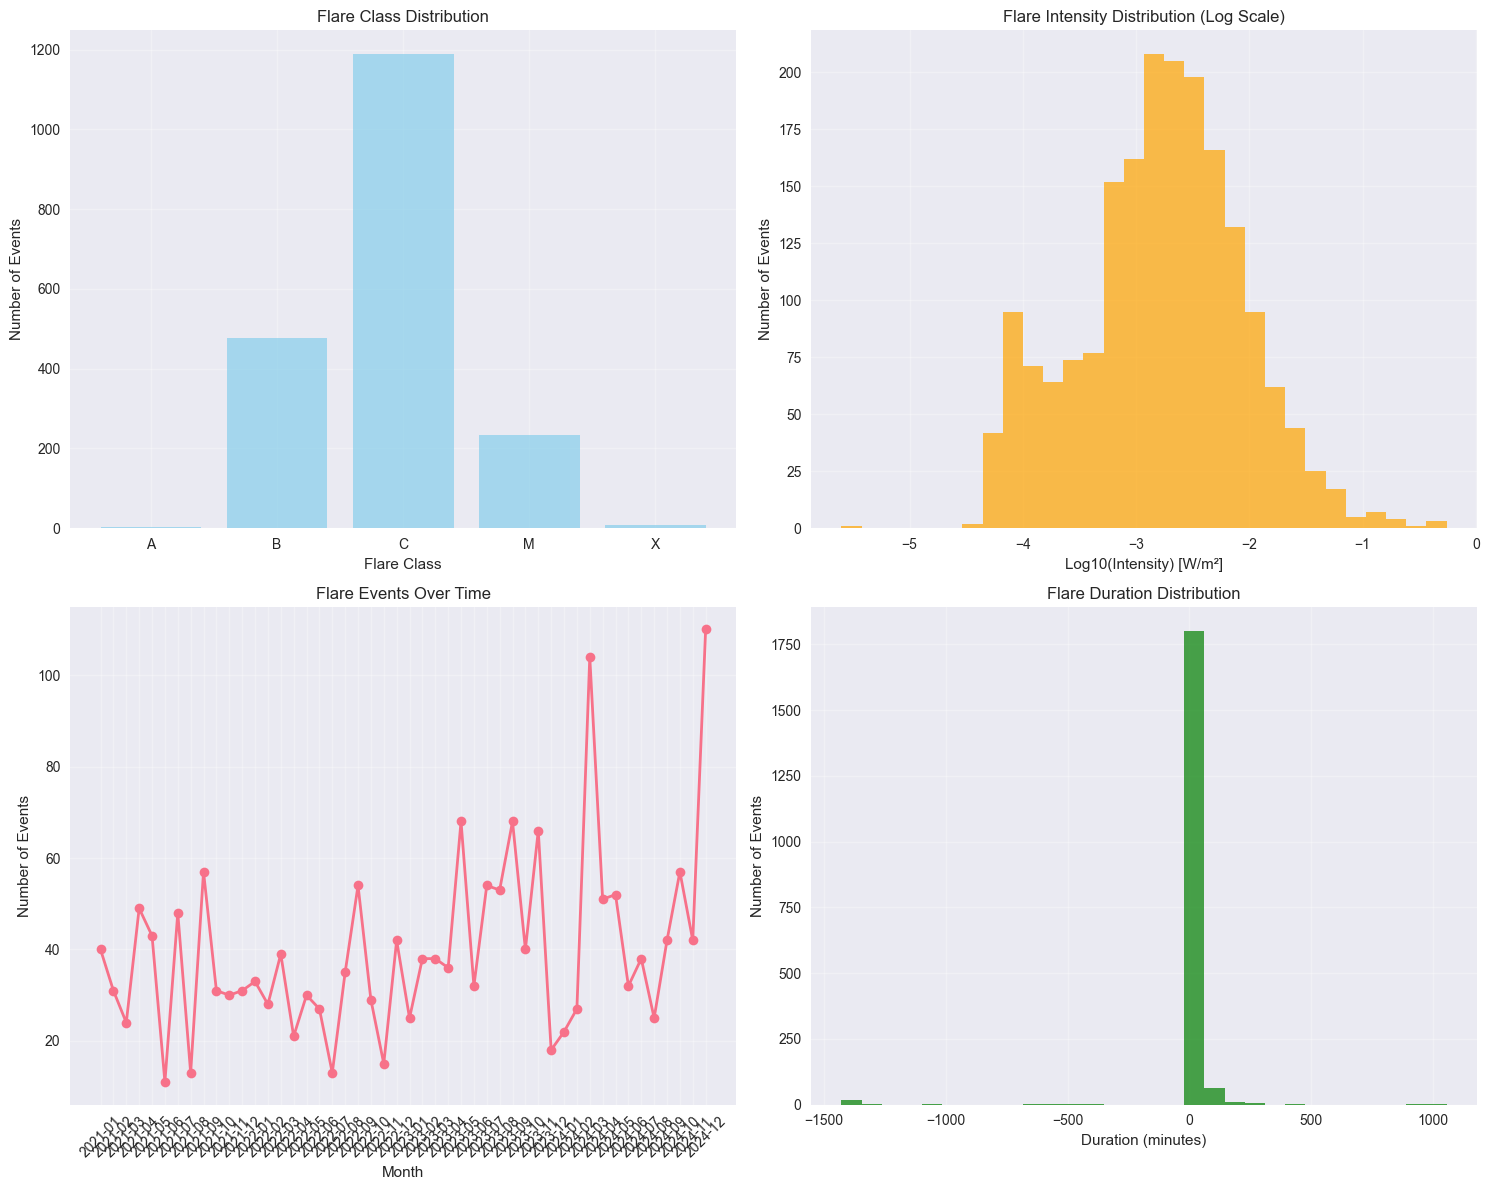


=== HIGH-ENERGY FLARES (M & X CLASS) ===
Total M & X class flares: 243
Date range: 2021-07-03 to 2024-12-30
M-class: 235
X-class: 8

=== STRONGEST FLARES ===
      date          begin_time flare_class  intensity
2024-05-29 2024-05-29 14:11:00        X1.4       0.55
2024-02-22 2024-02-22 22:08:00        X6.3       0.45
2024-10-07 2024-10-07 20:03:00        X1.0       0.44
2024-05-15 2024-05-15 14:20:00        X2.9       0.36
2024-08-02 2024-08-02 04:23:00        M7.3       0.23
2024-08-02 2024-08-02 04:23:00        M7.4       0.23
2024-05-08 2024-05-08 21:08:00        X1.0       0.20
2022-08-30 2022-08-30 18:04:00        M2.1       0.19
2024-02-28 2024-02-28 16:24:00        M1.5       0.16
2024-05-06 2024-05-06 21:58:00        M4.3       0.12


In [ ]:
# Visualize flare events
if not flare_events_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Flare class distribution
    class_counts = flare_events_df['class_letter'].value_counts().sort_index()
    axes[0, 0].bar(class_counts.index, class_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Flare Class Distribution')
    axes[0, 0].set_xlabel('Flare Class')
    axes[0, 0].set_ylabel('Number of Events')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Flare intensity distribution (log scale)
    valid_intensities = flare_events_df[flare_events_df['intensity'] > 0]['intensity']
    axes[0, 1].hist(np.log10(valid_intensities), bins=30, color='orange', alpha=0.7)
    axes[0, 1].set_title('Flare Intensity Distribution (Log Scale)')
    axes[0, 1].set_xlabel('Log10(Intensity) [W/m²]')
    axes[0, 1].set_ylabel('Number of Events')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Flare events over time
    flare_events_df['month'] = pd.to_datetime(flare_events_df['date']).dt.to_period('M')
    monthly_counts = flare_events_df.groupby('month').size()
    axes[1, 0].plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o', linewidth=2)
    axes[1, 0].set_title('Flare Events Over Time')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Number of Events')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Duration distribution for events with valid duration
    valid_durations = flare_events_df.dropna(subset=['duration_minutes'])
    if len(valid_durations) > 0:
        axes[1, 1].hist(valid_durations['duration_minutes'], bins=30, color='green', alpha=0.7)
        axes[1, 1].set_title('Flare Duration Distribution')
        axes[1, 1].set_xlabel('Duration (minutes)')
        axes[1, 1].set_ylabel('Number of Events')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No duration data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Flare Duration Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # High-energy flare summary (M and X class)
    high_energy = flare_events_df[flare_events_df['class_letter'].isin(['M', 'X'])]
    print(f"\n=== HIGH-ENERGY FLARES (M & X CLASS) ===")
    print(f"Total M & X class flares: {len(high_energy)}")
    if len(high_energy) > 0:
        print(f"Date range: {high_energy['date'].min()} to {high_energy['date'].max()}")
        print(f"M-class: {len(high_energy[high_energy['class_letter'] == 'M'])}")
        print(f"X-class: {len(high_energy[high_energy['class_letter'] == 'X'])}")
        
        print(f"\n=== STRONGEST FLARES ===")
        strongest = high_energy.nlargest(10, 'intensity')[['date', 'begin_time', 'flare_class', 'intensity']]
        print(strongest.to_string(index=False))
else:
    print("No flare data to visualize!")

## HMI Magnetic Field Data Processing

Load and process the SDO/HMI magnetic field data.

In [ ]:
def load_hmi_data(hmi_dir: Path) -> Dict[str, np.ndarray]:
    """
    Load HMI magnetic field data from FITS files.
    
    Args:
        hmi_dir: Directory containing HMI FITS files
        
    Returns:
        Dictionary with magnetic field components
    """
    hmi_data = {}
    
    # Expected file types
    field_types = ['azimuth', 'inclination', 'field', 'disambig']
    
    for field_type in field_types:
        # Look for files with this field type
        fits_files = list(hmi_dir.glob(f"*{field_type}.fits"))
        
        if fits_files:
            fits_file = fits_files[0]  # Take the first match
            print(f"Loading {field_type} data from {fits_file.name}...")
            
            try:
                with fits.open(fits_file) as hdul:
                    # HMI data is typically in HDU 1
                    data = hdul[1].data
                    header = hdul[1].header
                    
                    hmi_data[field_type] = {
                        'data': data,
                        'header': header,
                        'file': fits_file.name
                    }
                    
                    print(f"  Shape: {data.shape}")
                    print(f"  Data type: {data.dtype}")
                    print(f"  Valid range: [{np.nanmin(data):.3f}, {np.nanmax(data):.3f}]")
                    
            except Exception as e:
                print(f"  Error loading {fits_file}: {e}")
        else:
            print(f"No {field_type} files found in {hmi_dir}")
    
    return hmi_data

def get_hmi_timestamp(hmi_dir_name: str) -> datetime:
    """
    Extract timestamp from HMI directory name.
    
    Args:
        hmi_dir_name: Name like 'hmi.B_720s.20220101_000000_TAI'
        
    Returns:
        Datetime object
    """
    # Extract the timestamp part
    parts = hmi_dir_name.split('.')
    if len(parts) >= 3:
        timestamp_str = parts[2].replace('_TAI', '')  # Remove TAI suffix
        # Format: YYYYMMDD_HHMMSS
        if '_' in timestamp_str:
            date_part, time_part = timestamp_str.split('_')
            dt_str = f"{date_part}_{time_part}"
            return datetime.strptime(dt_str, "%Y%m%d_%H%M%S")
        else:
            # Sometimes only date is provided
            return datetime.strptime(timestamp_str, "%Y%m%d")
    
    raise ValueError(f"Cannot parse timestamp from {hmi_dir_name}")

def process_hmi_data_for_ml(hmi_data: Dict[str, np.ndarray], 
                           target_size: Optional[Tuple[int, int]] = None) -> Dict[str, np.ndarray]:
    """
    Process HMI data for machine learning input.
    
    Args:
        hmi_data: Raw HMI data dictionary
        target_size: Optional target size for resizing
        
    Returns:
        Processed data dictionary
    """
    processed = {}
    
    for field_type, field_info in hmi_data.items():
        data = field_info['data']
        
        # Handle NaN values
        data_clean = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Normalize based on field type
        if field_type == 'azimuth':
            # Azimuth: 0-360 degrees, normalize to 0-1
            normalized = data_clean / 360.0
        elif field_type == 'inclination':
            # Inclination: 0-180 degrees, normalize to 0-1  
            normalized = data_clean / 180.0
        elif field_type == 'field':
            # Field strength: variable range, use robust normalization
            p1, p99 = np.percentile(data_clean[data_clean > 0], [1, 99])
            normalized = np.clip((data_clean - p1) / (p99 - p1), 0, 1)
        else:
            # For other fields, use min-max normalization
            data_min, data_max = np.min(data_clean), np.max(data_clean)
            if data_max > data_min:
                normalized = (data_clean - data_min) / (data_max - data_min)
            else:
                normalized = data_clean
        
        processed[field_type] = normalized
        
        print(f"{field_type}: normalized range [{np.min(normalized):.3f}, {np.max(normalized):.3f}]")
    
    return processed

In [ ]:
# Find and load HMI data
hmi_dirs = list(DATA_DIR.glob("hmi*"))
print(f"Found {len(hmi_dirs)} HMI data directories:")

hmi_datasets = {}

for hmi_dir in sorted(hmi_dirs):
    print(f"\n=== Processing {hmi_dir.name} ===")
    
    try:
        # Extract timestamp
        timestamp = get_hmi_timestamp(hmi_dir.name)
        print(f"Timestamp: {timestamp}")
        
        # Load HMI data
        hmi_data = load_hmi_data(hmi_dir)
        
        if hmi_data:
            # Process for ML
            processed_data = process_hmi_data_for_ml(hmi_data)
            
            hmi_datasets[timestamp] = {
                'raw_data': hmi_data,
                'processed_data': processed_data,
                'directory': hmi_dir.name
            }
            
            print(f"Successfully loaded {len(processed_data)} field types")
        else:
            print("No data loaded")
            
    except Exception as e:
        print(f"Error processing {hmi_dir.name}: {e}")

print(f"\n=== HMI DATA SUMMARY ===")
print(f"Successfully loaded {len(hmi_datasets)} HMI datasets")

if hmi_datasets:
    timestamps = sorted(hmi_datasets.keys())
    print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
    
    # Show available field types
    sample_dataset = next(iter(hmi_datasets.values()))
    field_types = list(sample_dataset['processed_data'].keys())
    print(f"Available field types: {field_types}")
    
    # Show data shapes
    for field_type in field_types:
        shape = sample_dataset['processed_data'][field_type].shape
        print(f"  {field_type}: {shape}")

Found 1 HMI data directories:

=== Processing hmi.B_720s.20220101_000000_TAI ===
Timestamp: 2022-01-01 00:00:00
Loading azimuth data from hmi.B_720s.20220101_000000_TAI.azimuth.fits...
  Shape: (4096, 4096)
  Data type: float64
  Valid range: [0.000, 180.000]
Loading inclination data from hmi.B_720s.20220101_000000_TAI.inclination.fits...
  Shape: (4096, 4096)
  Data type: float64
  Valid range: [0.000, 180.000]
Loading field data from hmi.B_720s.20220101_000000_TAI.field.fits...
  Shape: (4096, 4096)
  Data type: float64
  Valid range: [5.000, 2557.140]
Loading disambig data from hmi.B_720s.20220101_000000_TAI.disambig.fits...
  Shape: (4096, 4096)
  Data type: int8
  Valid range: [0.000, 7.000]
azimuth: normalized range [0.000, 0.500]
inclination: normalized range [0.000, 1.000]
field: normalized range [0.000, 1.000]
disambig: normalized range [0.000, 1.000]
Successfully loaded 4 field types

=== HMI DATA SUMMARY ===
Successfully loaded 1 HMI datasets
Time range: 2022-01-01 00:00:00 

Visualizing data from: 2022-01-01 00:00:00


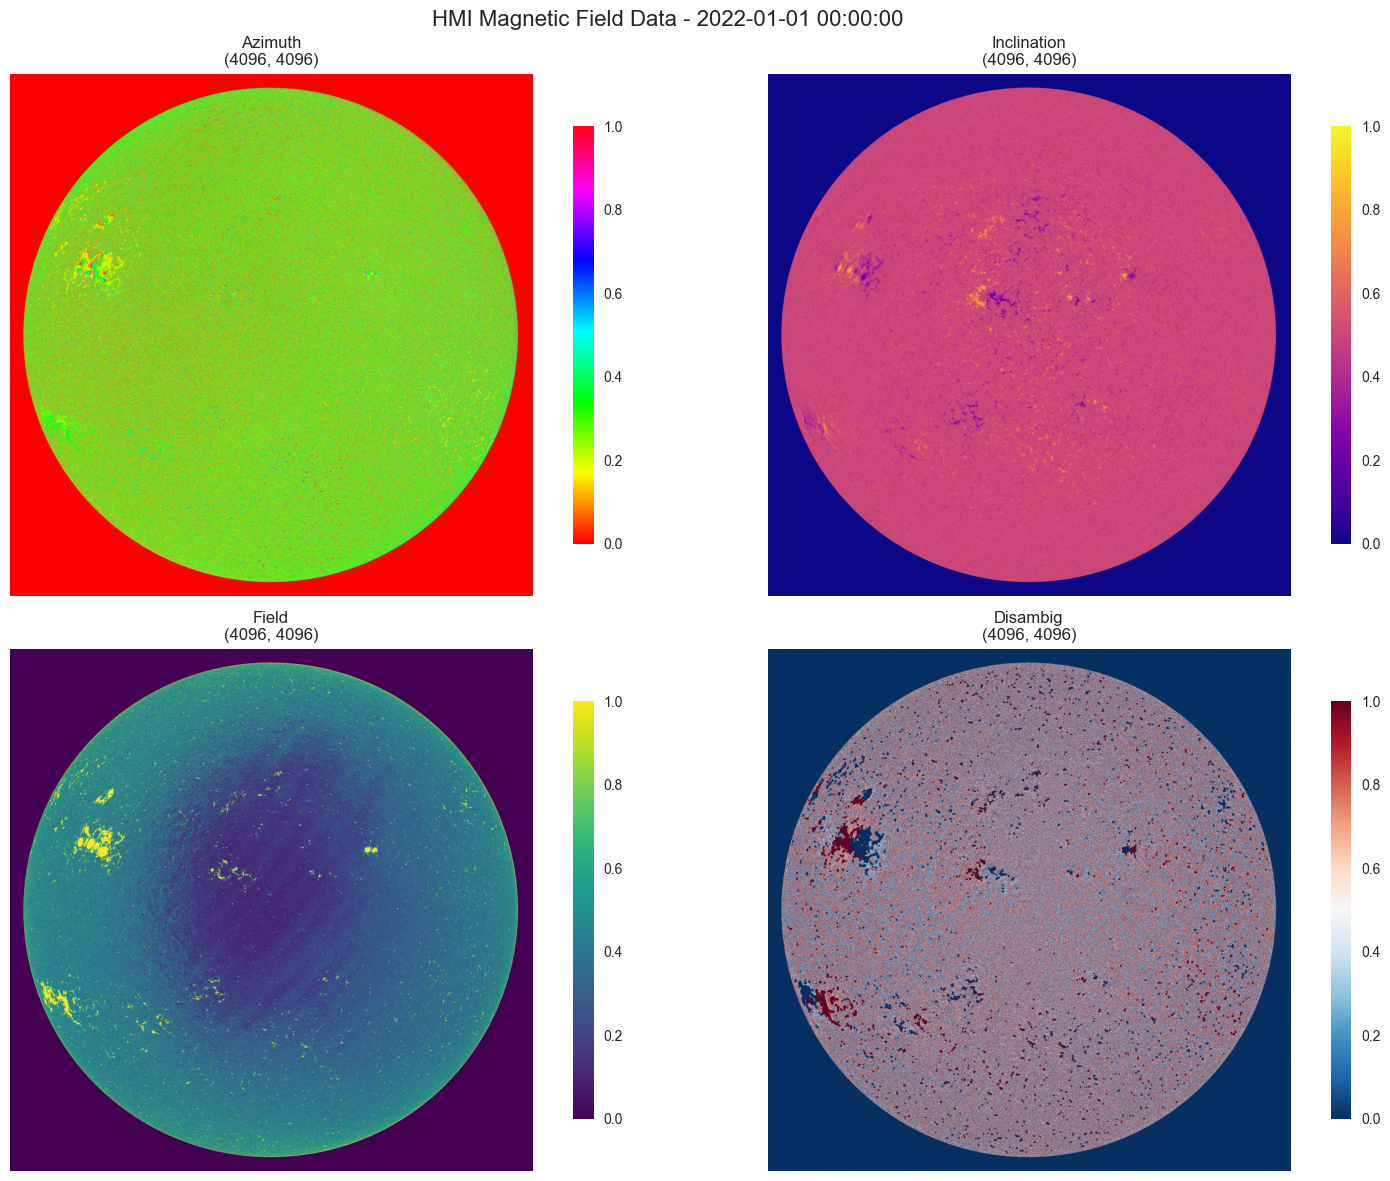


=== DATA STATISTICS ===

AZIMUTH:
  Shape: (4096, 4096)
  Range: [0.0000, 0.5000]
  Mean: 0.1768
  Std: 0.1681
  Non-zero pixels: 11,779,676 (70.2%)

INCLINATION:
  Shape: (4096, 4096)
  Range: [0.0000, 1.0000]
  Mean: 0.3509
  Std: 0.2306
  Non-zero pixels: 11,780,046 (70.2%)

FIELD:
  Shape: (4096, 4096)
  Range: [0.0000, 1.0000]
  Mean: 0.2537
  Std: 0.2283
  Non-zero pixels: 11,662,223 (69.5%)

DISAMBIG:
  Shape: (4096, 4096)
  Range: [0.0000, 1.0000]
  Mean: 0.3482
  Std: 0.3665
  Non-zero pixels: 9,905,685 (59.0%)


In [ ]:
# Visualize HMI data
if hmi_datasets:
    # Get the first available dataset for visualization
    sample_timestamp = sorted(hmi_datasets.keys())[0]
    sample_data = hmi_datasets[sample_timestamp]['processed_data']
    raw_data = hmi_datasets[sample_timestamp]['raw_data']
    
    print(f"Visualizing data from: {sample_timestamp}")
    
    # Create subplot for each field type
    field_types = list(sample_data.keys())
    n_fields = len(field_types)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, field_type in enumerate(field_types):
        if i < len(axes):
            data = sample_data[field_type]
            
            # Use appropriate colormap
            if field_type == 'azimuth':
                cmap = 'hsv'  # Circular colormap for azimuth
                vmin, vmax = 0, 1
            elif field_type == 'inclination':
                cmap = 'plasma'
                vmin, vmax = 0, 1
            elif field_type == 'field':
                cmap = 'viridis'
                vmin, vmax = 0, 1
            else:
                cmap = 'RdBu_r'
                vmin, vmax = 0, 1
            
            im = axes[i].imshow(data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
            axes[i].set_title(f'{field_type.title()}\n{data.shape}')
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i], shrink=0.8)
    
    # Hide unused subplots
    for i in range(len(field_types), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'HMI Magnetic Field Data - {sample_timestamp.strftime("%Y-%m-%d %H:%M:%S")}', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Display statistics
    print(f"\n=== DATA STATISTICS ===")
    for field_type, data in sample_data.items():
        print(f"\n{field_type.upper()}:")
        print(f"  Shape: {data.shape}")
        print(f"  Range: [{np.min(data):.4f}, {np.max(data):.4f}]")
        print(f"  Mean: {np.mean(data):.4f}")
        print(f"  Std: {np.std(data):.4f}")
        print(f"  Non-zero pixels: {np.count_nonzero(data):,} ({100*np.count_nonzero(data)/data.size:.1f}%)")

else:
    print("No HMI data available for visualization!")

In [ ]:
# Quick test to see what we actually parsed
print("Sample of flare events:")
print(flare_events_df[['flare_class', 'class_letter', 'class_number', 'intensity']].head(20))
print(f"\nUnique flare classes: {sorted(flare_events_df['flare_class'].unique())}")
print(f"Unique class letters: {sorted(flare_events_df['class_letter'].unique())}")
print(f"Class letter counts: {flare_events_df['class_letter'].value_counts()}")

Sample of flare events:
   flare_class class_letter  class_number  intensity
0         B3.1            B           3.1   0.000088
1         B2.1            B           2.1   0.000064
2         B1.9            B           1.9   0.000057
3         A4.3            A           4.3   0.000062
4         B2.8            B           2.8   0.000170
5         B1.2            B           1.2   0.000065
6         B1.5            B           1.5   0.000051
7         B1.1            B           1.1   0.000066
8         B1.1            B           1.1   0.000047
9         B1.1            B           1.1   0.000091
10        C1.0            C           1.0   0.000360
11        B1.3            B           1.3   0.000062
12        B2.6            B           2.6   0.000160
13        B4.1            B           4.1   0.000230
14        B1.7            B           1.7   0.000110
15        B7.0            B           7.0   0.000280
16        B1.8            B           1.8   0.000096
17        B1.6        

1. Downsample or extract features from the large HMI images
2. Create time-series with regular intervals
3. Label each time step with flare occurrence
4. Generate sequences for LSTM input

In [ ]:
def downsample_hmi_data(hmi_data: Dict[str, np.ndarray], 
                        target_size: Tuple[int, int] = (128, 128)) -> Dict[str, np.ndarray]:
    """
    Downsample HMI data from 4096x4096 to a smaller size for LSTM processing.
    
    Args:
        hmi_data: Dictionary containing HMI field data
        target_size: Target dimensions for downsampling
        
    Returns:
        Dictionary with downsampled data
    """
    from skimage.transform import resize
    import warnings
    warnings.filterwarnings('ignore')
    
    downsampled = {}
    
    for field_type, data in hmi_data.items():
        # Resize using anti-aliasing
        resized_data = resize(data, target_size, anti_aliasing=True, preserve_range=True)
        downsampled[field_type] = resized_data.astype(np.float32)
        
        print(f"{field_type}: {data.shape} -> {resized_data.shape}")
    
    return downsampled

def extract_hmi_features(hmi_data: Dict[str, np.ndarray], 
                        region_size: int = 64) -> Dict[str, np.ndarray]:
    """
    Extract features from HMI data using statistical measures over regions.
    
    Args:
        hmi_data: Dictionary containing HMI field data
        region_size: Size of regions to compute statistics over
        
    Returns:
        Dictionary with extracted features
    """
    features = {}
    
    for field_type, data in hmi_data.items():
        h, w = data.shape
        # Calculate how many regions we can fit
        n_regions_h = h // region_size
        n_regions_w = w // region_size
        
        # Extract statistics for each region
        region_stats = []
        
        for i in range(n_regions_h):
            for j in range(n_regions_w):
                region = data[i*region_size:(i+1)*region_size, 
                             j*region_size:(j+1)*region_size]
                
                # Compute statistics
                stats = [
                    np.mean(region),
                    np.std(region),
                    np.max(region),
                    np.min(region),
                    np.median(region)
                ]
                region_stats.extend(stats)
        
        features[f"{field_type}_stats"] = np.array(region_stats, dtype=np.float32)
        print(f"{field_type}: extracted {len(region_stats)} statistical features")
    
    return features

def create_flare_labels(timestamps: List[datetime], 
                       flare_events: pd.DataFrame,
                       time_window_hours: int = 24) -> np.ndarray:
    """
    Create binary labels for flare occurrence within time windows.
    
    Args:
        timestamps: List of observation timestamps
        flare_events: DataFrame with flare events
        time_window_hours: Hours to look ahead for flare occurrence
        
    Returns:
        Binary array indicating flare occurrence
    """
    labels = np.zeros(len(timestamps), dtype=int)
    
    for i, timestamp in enumerate(timestamps):
        window_start = timestamp
        window_end = timestamp + timedelta(hours=time_window_hours)
        
        # Check if any flare occurs in this window
        flares_in_window = flare_events[
            (flare_events['begin_time'] >= window_start) &
            (flare_events['begin_time'] <= window_end)
        ]
        
        if len(flares_in_window) > 0:
            labels[i] = 1
            
    return labels

def create_flare_intensity_labels(timestamps: List[datetime], 
                                 flare_events: pd.DataFrame,
                                 time_window_hours: int = 24) -> np.ndarray:
    """
    Create labels for maximum flare intensity within time windows.
    
    Args:
        timestamps: List of observation timestamps
        flare_events: DataFrame with flare events
        time_window_hours: Hours to look ahead for flare occurrence
        
    Returns:
        Array with maximum flare class (0=no flare, 1=B, 2=C, 3=M, 4=X)
    """
    labels = np.zeros(len(timestamps), dtype=int)
    
    for i, timestamp in enumerate(timestamps):
        window_start = timestamp
        window_end = timestamp + timedelta(hours=time_window_hours)
        
        # Check for flares in this window
        flares_in_window = flare_events[
            (flare_events['begin_time'] >= window_start) &
            (flare_events['begin_time'] <= window_end)
        ]
        
        if len(flares_in_window) > 0:
            # Get the maximum flare class in the window
            max_class = flares_in_window['class_numeric'].max()
            labels[i] = max_class
            
    return labels

# Test feature extraction on our single HMI dataset
if hmi_datasets:
    print("=== TESTING FEATURE EXTRACTION ===")
    
    # Get the sample dataset
    sample_timestamp = sorted(hmi_datasets.keys())[0]
    sample_data = hmi_datasets[sample_timestamp]['processed_data']
    
    print(f"Original data shapes:")
    for field_type, data in sample_data.items():
        print(f"  {field_type}: {data.shape}")
    
    # Test downsampling
    print(f"\n1. Downsampling to 128x128:")
    downsampled = downsample_hmi_data(sample_data, target_size=(128, 128))
    
    # Test feature extraction  
    print(f"\n2. Extracting statistical features:")
    statistical_features = extract_hmi_features(sample_data, region_size=128)
    
    print(f"\n=== FEATURE SUMMARY ===")
    total_features = sum(len(features) for features in statistical_features.values())
    print(f"Total statistical features: {total_features}")
    
    # Test labeling (we need more data for this to be meaningful)
    print(f"\n3. Testing flare labeling:")
    test_timestamps = [sample_timestamp]
    test_labels = create_flare_labels(test_timestamps, flare_events_clean, time_window_hours=24)
    intensity_labels = create_flare_intensity_labels(test_timestamps, flare_events_clean, time_window_hours=24)
    
    print(f"Sample timestamp: {sample_timestamp}")
    print(f"Flare occurrence label: {test_labels[0]}")
    print(f"Max flare intensity label: {intensity_labels[0]}")
    
else:
    print("No HMI data available for feature extraction testing!")

=== TESTING FEATURE EXTRACTION ===


Original data shapes:
  azimuth: (4096, 4096)
  inclination: (4096, 4096)
  field: (4096, 4096)
  disambig: (4096, 4096)

1. Downsampling to 128x128:
azimuth: (4096, 4096) -> (128, 128)
inclination: (4096, 4096) -> (128, 128)
field: (4096, 4096) -> (128, 128)
disambig: (4096, 4096) -> (128, 128)

2. Extracting statistical features:
azimuth: extracted 5120 statistical features
inclination: extracted 5120 statistical features
field: extracted 5120 statistical features
disambig: extracted 5120 statistical features

=== FEATURE SUMMARY ===
Total statistical features: 20480

3. Testing flare labeling:
Sample timestamp: 2022-01-01 00:00:00
Flare occurrence label: 1
Max flare intensity label: 1


In [ ]:
# Analyze 2022 M and X class flares for JSOC data download
print("=== ANALYZING 2022 M AND X CLASS FLARES ===")

# Convert date column to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(flare_events_clean['date']):
    flare_events_clean['date'] = pd.to_datetime(flare_events_clean['date'])

# Filter for 2022 M and X class flares
year_2022_flares = flare_events_clean[flare_events_clean['date'].dt.year == 2022]
mx_class_flares = year_2022_flares[year_2022_flares['class_letter'].isin(['M', 'X'])]

print(f"Total 2022 flares: {len(year_2022_flares)}")
print(f"M and X class flares in 2022: {len(mx_class_flares)}")

if len(mx_class_flares) > 0:
    # Separate M and X class
    m_class_2022 = mx_class_flares[mx_class_flares['class_letter'] == 'M'].sort_values('begin_time')
    x_class_2022 = mx_class_flares[mx_class_flares['class_letter'] == 'X'].sort_values('begin_time')
    
    print(f"M-class flares in 2022: {len(m_class_2022)}")
    print(f"X-class flares in 2022: {len(x_class_2022)}")
    
    # Get first 10 timestamps for each class
    first_10_m = m_class_2022.head(10) if len(m_class_2022) >= 10 else m_class_2022
    first_10_x = x_class_2022.head(10) if len(x_class_2022) >= 10 else x_class_2022
    
    print(f"\n=== FIRST 10 M-CLASS FLARES (2022) ===")
    for i, (_, flare) in enumerate(first_10_m.iterrows(), 1):
        print(f"{i:2d}. {flare['begin_time'].strftime('%Y-%m-%d %H:%M')} - {flare['flare_class']}")
    
    print(f"\n=== FIRST 10 X-CLASS FLARES (2022) ===")
    for i, (_, flare) in enumerate(first_10_x.iterrows(), 1):
        print(f"{i:2d}. {flare['begin_time'].strftime('%Y-%m-%d %H:%M')} - {flare['flare_class']}")
    
    # Create list of all timestamps we need (combine M and X class)
    all_target_flares = pd.concat([first_10_m, first_10_x]).sort_values('begin_time')
    
    print(f"\n=== COMBINED TARGET FLARES (Total: {len(all_target_flares)}) ===")
    for i, (_, flare) in enumerate(all_target_flares.iterrows(), 1):
        print(f"{i:2d}. {flare['begin_time'].strftime('%Y-%m-%d %H:%M')} - {flare['flare_class']}")
    
    # Generate JSOC timestamp format for downloads
    # We'll download data 12 hours before each flare for context
    jsoc_timestamps = []
    for _, flare in all_target_flares.iterrows():
        flare_time = flare['begin_time']
        # Download data 12 hours before the flare
        data_time = flare_time - timedelta(hours=12)
        jsoc_format = data_time.strftime('%Y.%m.%d_%H:%M:%S_TAI')
        jsoc_timestamps.append({
            'flare_class': flare['flare_class'],
            'flare_time': flare_time,
            'data_time': data_time,
            'jsoc_format': jsoc_format
        })
    
    print(f"\n=== JSOC DOWNLOAD TIMESTAMPS ===")
    print("(Data will be downloaded 12 hours before each flare)")
    for i, ts in enumerate(jsoc_timestamps, 1):
        print(f"{i:2d}. {ts['jsoc_format']} (for {ts['flare_class']} flare at {ts['flare_time'].strftime('%Y-%m-%d %H:%M')})")

else:
    print("No M or X class flares found in 2022!")
    jsoc_timestamps = []

=== ANALYZING 2022 M AND X CLASS FLARES ===
Total 2022 flares: 366
M and X class flares in 2022: 19
M-class flares in 2022: 19
X-class flares in 2022: 0

=== FIRST 10 M-CLASS FLARES (2022) ===
 1. 2022-01-29 22:45 - M1.1
 2. 2022-03-14 08:29 - M2.0
 3. 2022-03-25 05:02 - M1.4
 4. 2022-03-29 09:17 - M1.0
 5. 2022-04-17 02:00 - M1.8
 6. 2022-04-17 02:00 - M1.9
 7. 2022-04-29 18:01 - M1.2
 8. 2022-08-15 21:47 - M1.1
 9. 2022-08-26 10:41 - M2.1
10. 2022-08-29 18:45 - M4.7

=== FIRST 10 X-CLASS FLARES (2022) ===

=== COMBINED TARGET FLARES (Total: 10) ===
 1. 2022-01-29 22:45 - M1.1
 2. 2022-03-14 08:29 - M2.0
 3. 2022-03-25 05:02 - M1.4
 4. 2022-03-29 09:17 - M1.0
 5. 2022-04-17 02:00 - M1.8
 6. 2022-04-17 02:00 - M1.9
 7. 2022-04-29 18:01 - M1.2
 8. 2022-08-15 21:47 - M1.1
 9. 2022-08-26 10:41 - M2.1
10. 2022-08-29 18:45 - M4.7

=== JSOC DOWNLOAD TIMESTAMPS ===
(Data will be downloaded 12 hours before each flare)
 1. 2022.01.29_10:45:00_TAI (for M1.1 flare at 2022-01-29 22:45)
 2. 2022.03

=== PLOTTING ALL AVAILABLE HMI DATA ===
Creating plots for 1 HMI datasets...
\nPlotting 1/1: 2022-01-01 00:00:00
Saved: hmi_data_20220101_000000.png


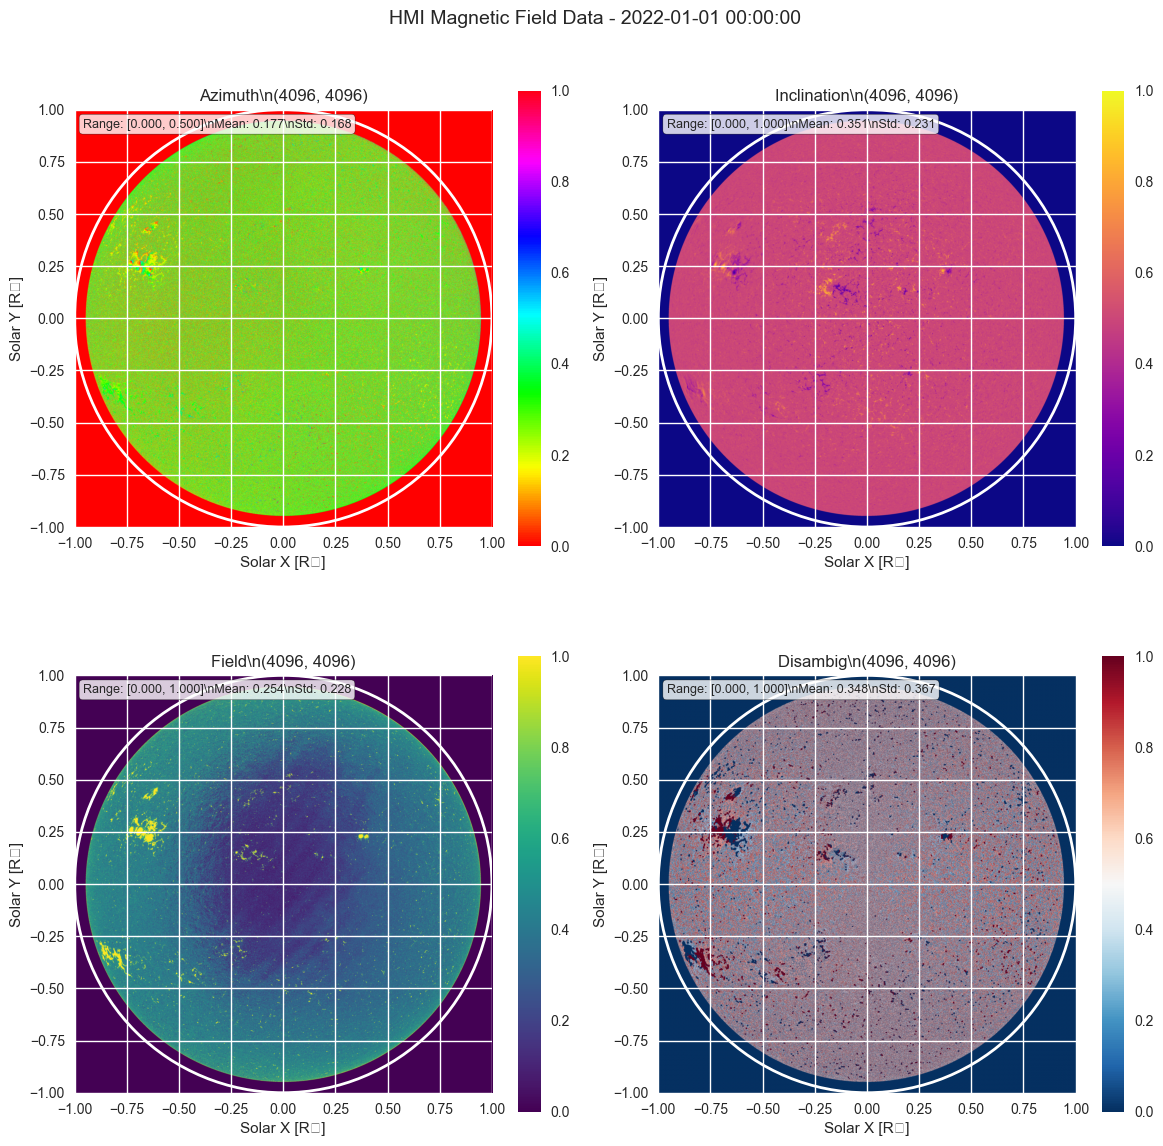

  Data Summary for 2022-01-01 00:00:00:
    azimuth: (4096, 4096), 11,779,676/16,777,216 non-zero (70.2%)
    inclination: (4096, 4096), 11,780,046/16,777,216 non-zero (70.2%)
    field: (4096, 4096), 11,662,223/16,777,216 non-zero (69.5%)
    disambig: (4096, 4096), 9,905,685/16,777,216 non-zero (59.0%)

Plots created for 1 datasets
Plots saved to: plots/


In [ ]:
def plot_all_hmi_data(hmi_datasets: Dict[datetime, Dict], 
                      flare_events: pd.DataFrame = None,
                      save_plots: bool = True,
                      plot_dir: str = 'plots'):
    """
    Create comprehensive plots for all available HMI data timestamps.
    
    Args:
        hmi_datasets: Dictionary of HMI datasets indexed by timestamp
        flare_events: DataFrame with flare events for context
        save_plots: Whether to save plots to disk
        plot_dir: Directory to save plots
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Circle
    import os
    
    if save_plots:
        os.makedirs(plot_dir, exist_ok=True)
    
    timestamps = sorted(hmi_datasets.keys())
    n_timestamps = len(timestamps)
    
    print(f"Creating plots for {n_timestamps} HMI datasets...")
    
    # 1. Overview plot: All timestamps with flare context
    if n_timestamps > 1:
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot timeline
        ax.scatter([ts for ts in timestamps], [1]*len(timestamps), 
                  s=100, c='blue', alpha=0.7, label='HMI Observations')
        
        # Add flare events if provided
        if flare_events is not None:
            # Filter flares around our observation times
            start_time = min(timestamps) - timedelta(days=1)
            end_time = max(timestamps) + timedelta(days=1)
            
            nearby_flares = flare_events[
                (flare_events['begin_time'] >= start_time) &
                (flare_events['begin_time'] <= end_time)
            ]
            
            # Color code by flare class
            colors = {'B': 'green', 'C': 'orange', 'M': 'red', 'X': 'purple'}
            sizes = {'B': 30, 'C': 50, 'M': 80, 'X': 120}
            
            for flare_class in ['B', 'C', 'M', 'X']:
                class_flares = nearby_flares[nearby_flares['class_letter'] == flare_class]
                if len(class_flares) > 0:
                    ax.scatter(class_flares['begin_time'], [0.5]*len(class_flares),
                             s=sizes[flare_class], c=colors[flare_class], 
                             alpha=0.8, label=f'{flare_class}-class flares')
        
        ax.set_ylim(0, 1.5)
        ax.set_xlabel('Time')
        ax.set_title('HMI Observations Timeline with Solar Flare Context')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(plot_dir, 'hmi_timeline_overview.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # 2. Individual timestamp plots
    for i, timestamp in enumerate(timestamps):
        print(f"\\nPlotting {i+1}/{n_timestamps}: {timestamp}")
        
        hmi_data = hmi_datasets[timestamp]['processed_data']
        available_fields = list(hmi_data.keys())
        
        # Create subplot layout
        n_fields = len(available_fields)
        if n_fields <= 2:
            fig, axes = plt.subplots(1, n_fields, figsize=(6*n_fields, 6))
        elif n_fields <= 4:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        else:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        if n_fields == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        # Plot each field
        for j, field_type in enumerate(available_fields):
            if j >= len(axes):
                break
                
            data = hmi_data[field_type]
            
            # Choose appropriate colormap
            if field_type == 'azimuth':
                cmap = 'hsv'  # Circular colormap for azimuth
                vmin, vmax = 0, 1
            elif field_type == 'inclination':
                cmap = 'plasma'
                vmin, vmax = 0, 1
            elif field_type == 'field':
                cmap = 'viridis'
                vmin, vmax = 0, 1
            else:
                cmap = 'RdBu_r'
                vmin, vmax = 0, 1
            
            # Create the image
            im = axes[j].imshow(data, cmap=cmap, origin='lower', 
                              vmin=vmin, vmax=vmax, extent=[-1, 1, -1, 1])
            
            # Add solar disk circle
            circle = Circle((0, 0), 1, fill=False, color='white', linewidth=2)
            axes[j].add_patch(circle)
            
            axes[j].set_title(f'{field_type.title()}\\n{data.shape}', fontsize=12)
            axes[j].set_xlabel('Solar X [R☉]')
            axes[j].set_ylabel('Solar Y [R☉]')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[j], shrink=0.8)
            
            # Add statistics
            stats_text = f'Range: [{np.min(data):.3f}, {np.max(data):.3f}]\\n'
            stats_text += f'Mean: {np.mean(data):.3f}\\n'
            stats_text += f'Std: {np.std(data):.3f}'
            
            axes[j].text(0.02, 0.98, stats_text, transform=axes[j].transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round', 
                        facecolor='white', alpha=0.8), fontsize=9)
        
        # Hide unused subplots
        for j in range(len(available_fields), len(axes)):
            axes[j].set_visible(False)
        
        # Add timestamp and flare context to title
        title = f'HMI Magnetic Field Data - {timestamp.strftime("%Y-%m-%d %H:%M:%S")}'
        
        # Check for nearby flares
        if flare_events is not None:
            nearby_flares = flare_events[
                (flare_events['begin_time'] >= timestamp - timedelta(hours=12)) &
                (flare_events['begin_time'] <= timestamp + timedelta(hours=12))
            ]
            
            if len(nearby_flares) > 0:
                mx_flares = nearby_flares[nearby_flares['class_letter'].isin(['M', 'X'])]
                if len(mx_flares) > 0:
                    flare_info = ', '.join([f"{row['flare_class']}" for _, row in mx_flares.iterrows()])
                    title += f'\\n(M/X flares within ±12h: {flare_info})'
        
        plt.suptitle(title, fontsize=14, y=0.98)
        plt.tight_layout()
        
        if save_plots:
            filename = f'hmi_data_{timestamp.strftime("%Y%m%d_%H%M%S")}.png'
            plt.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')
            print(f"Saved: {filename}")
        
        plt.show()
        
        # Print data summary
        print(f"  Data Summary for {timestamp}:")
        for field_type, data in hmi_data.items():
            non_zero = np.count_nonzero(data)
            total = data.size
            print(f"    {field_type}: {data.shape}, {non_zero:,}/{total:,} non-zero ({100*non_zero/total:.1f}%)")

# Plot all currently available HMI data
print("=== PLOTTING ALL AVAILABLE HMI DATA ===")

if len(hmi_datasets) > 0:
    plot_all_hmi_data(hmi_datasets, flare_events_clean, save_plots=True)
    print(f"\nPlots created for {len(hmi_datasets)} datasets")
    print("Plots saved to: plots/")
else:
    print("No HMI datasets available to plot")